In [1]:
import numpy as np
from sympy import *
from matplotlib import pyplot as plt

In [2]:
def Hadamard(i):
    global N_qubit
    H=np.identity(2*N_qubit)
    H[i,i+N_qubit]=-1
    H[i+N_qubit,i]=1
    H[i,i]=0.
    H[i+N_qubit,i+N_qubit]=0.
    
    return H
    

In [3]:
def x_parity(i,j):
    global N_qubit
    x_par=Hadamard(i)@SUM(i,j)@np.linalg.inv(Hadamard(i))
    
    return x_par

In [4]:
def SUM(i,j):
    global N_qubit
    Sum_ij=np.identity(2*N_qubit)
    Sum_ij[i+N_qubit,j+N_qubit]=-1.0
    Sum_ij[j,i]=1.0
    
    return Sum_ij

In [5]:
def inv_SUM(i,j):
    return np.linalg.inv(SUM(i,j))

In [6]:
def CZ(i,j):
    global N_qubit
    CZ=Hadamard(j)@SUM(i,j)@np.linalg.inv(Hadamard(j))
    
    return CZ

In [7]:
def inv_CZ(i,j):
    return np.linalg.inv(CZ(i,j))

In [8]:
def logical_err(q,p):
    q_err=np.abs(Rs(2*np.sqrt(np.pi),q))
    p_err=np.abs(Rs(2*np.sqrt(np.pi),p))
    
    if q_err>0.5*np.sqrt(np.pi) or p_err>0.5*np.sqrt(np.pi):
        logic=1.0
    else:
        logic=0.
        
    return logic

In [9]:
def Rs(s,z):
    return z-s*np.floor(z/s+1/2)

## Initialize error vector

In [11]:
N_qubit=3

## First layer of encoder

In [13]:
A1=SUM(0,1)

A2=SUM(0,2)@A1

dec_cir=np.linalg.inv(A2)

In [17]:
print(dec_cir)

[[ 1.  0.  0.  0.  0.  0.]
 [-1.  1.  0.  0.  0.  0.]
 [-1.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.  1.]
 [ 0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.]]


In [18]:

C=np.transpose(np.linalg.inv(dec_cir))@np.linalg.inv(dec_cir)


In [19]:
# calculate the estimated zq, zp. Then perform error correction
z_q=np.zeros(2*N_qubit)
z_p=np.zeros(2*N_qubit)
for i in np.arange(2*N_qubit):
    z_q+=-1/C[0,0]*C[0,i]*dec_cir[i]
    z_p+=-1/C[N_qubit,N_qubit]*C[N_qubit,i]*dec_cir[i]

    
z_q+=1/C[0,0]*C[0,0]*dec_cir[0]
z_p+=1/C[N_qubit,N_qubit]*C[N_qubit,N_qubit]*dec_cir[N_qubit]
    
q_corrected=dec_cir[0]-z_q
p_corrected=dec_cir[N_qubit]-z_p

In [20]:
# Calculate variance after EC
print(np.sum(q_corrected**2))
print(np.sum(p_corrected**2))

0.3333333333333334
1.0


In [22]:
A_mtx=np.delete(dec_cir,0, axis=0)
A_mtx=np.delete(A_mtx,N_qubit-1, axis=0)

print(A_mtx)

[[-1.  1.  0.  0.  0.  0.]
 [-1.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.]]


In [23]:
mtx=dec_cir@(np.identity(6)-np.transpose(A_mtx)@np.linalg.inv(A_mtx@np.transpose(A_mtx))@A_mtx)

In [25]:
times=10**7

#corrected_state=np.zeros((times,6))

err_sweep=np.linspace(0.1,0.4,31)

logical_rate=np.zeros(err_sweep.shape[0])

In [26]:
for j in range(err_sweep.shape[0]):
    print(j)
    sigma=err_sweep[j]
    
    for i in range(times):
        s=np.random.normal(0.0,sigma,(6))

        syn=Rs(np.sqrt(2*np.pi),A_mtx@s)
        corrected_state=dec_cir@s-dec_cir@np.transpose(A_mtx)@np.linalg.inv(A_mtx@np.transpose(A_mtx))@syn
        q_out=corrected_state[0]
        p_out=corrected_state[3]
        
        logical_rate[j]+=1/times*logical_err(q_out,p_out)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


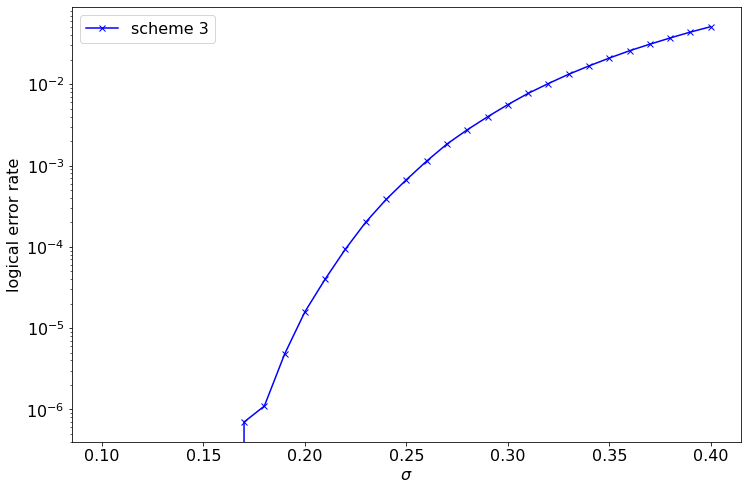

In [27]:
plt.figure(figsize=(12,8))
plt.plot(err_sweep, logical_rate,'xb-',label='scheme 3')
#plt.scatter(err_sweep, logical_rate)
plt.yscale('log')
plt.xlabel(r'$\sigma$',fontsize=16)
plt.ylabel('logical error rate',fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(fontsize=16)